## Hyperparameter Tuning

In [1]:
import torch
from transformers import AutoTokenizer, TrainingArguments, Trainer, DebertaV2ForSequenceClassification, AutoConfig
from datasets import DatasetDict
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.nn.functional as F
import json

In [18]:
# Load in tokenized datasets
tokenized = DatasetDict.load_from_disk('../processed/tokenized_DeBERTa_ds')

train_tokenized = tokenized['train']
val_tokenized = tokenized['validation']
test_tokenized = tokenized['test']

In [3]:
# Load tokenizer
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

C:\Users\User\Documents\school\Data Analysis projects\cyber_threat_nlp\.venv\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [4]:
# Reload label mappings
with open('../processed/label2id.json') as f:
    label2id = json.load(f)
with open('../processed/id2label.json') as f:
    id2label = json.load(f)
num_labels = len(label2id)

In [5]:
# Create focal loss class for better classification for imbalanced classes
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class DebertaForFocalLoss(DebertaV2ForSequenceClassification):
    def __init__(self, config, gamma=2.0, class_weights=None):
        super().__init__(config)
        self.focal = FocalLoss(gamma=gamma, weight=class_weights)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # Call DeBERTa forward WITHOUT passing labels
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=None,   # disable internal CE-loss
            **kwargs
        )

        logits = outputs.logits
        loss = None

        if labels is not None:
            loss = self.focal(logits, labels)

        # HuggingFace Trainer needs outputs.loss
        return {"loss": loss, "logits": logits}

In [6]:
# Create evaluation matrics function for trainer
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': acc
    }

In [7]:
# Create and add class weights
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


y_train = np.array(train_tokenized['labels'], dtype=int)

classes = np.unique(y_train)

class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
print('Class weights:', class_weights_np)

class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)

Class weights: [1.33855098 2.57130584 0.70456685 0.69218316]


In [8]:
def model_init():
    # Load config
    config = AutoConfig.from_pretrained(
        "microsoft/deberta-v3-base",
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    # Recreate model with custom class
    model = DebertaForFocalLoss.from_pretrained(
        MODEL_NAME,
        config=config,
        class_weights=class_weights,
        gamma=2.0
    )
    return model


In [9]:
# Create baseline training arguments for tuning
base_args = TrainingArguments(
    output_dir='../models/tuning_outputs',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,

    logging_steps=50,
    logging_strategy='steps',

    fp16=False,
    bf16=True
)

In [10]:
# Build trainer
trainer = Trainer(
    model_init=model_init,
    args=base_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\User\AppData\Local\Temp\ipykernel_30944\4247034050.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def hp_grid(trial):
    return {
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 2e-5, 3e-5]),
        'num_train_epochs': trial.suggest_categorical('num_train_epochs', [3, 4, 5]),
        'warmup_ratio': trial.suggest_categorical('warmup_ratio', [0.0, 0.1]),
        'weight_decay': trial.suggest_categorical('weight_decay', [0.01, 0.05])
    }

In [12]:
best_run = trainer.hyperparameter_search(
    direction='maximize',
    hp_space=hp_grid,
    n_trials=12
)
best_run

[I 2025-12-08 15:30:05,098] A new study created in memory with name: no-name-e045f3e4-8274-47cc-aa48-fc67d2b3bbd8
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.517200,0.404185,0.710794,0.735676,0.705882,0.705882
1,0.364600,0.372550,0.650502,0.728004,0.647059,0.647059
2,0.314300,0.428436,0.710867,0.714359,0.708556,0.708556
3,0.297900,0.372617,0.708385,0.731944,0.700535,0.700535


[I 2025-12-08 15:49:54,062] Trial 0 finished with value: 2.84139912070041 and parameters: {'learning_rate': 3e-05, 'num_train_epochs': 4, 'warmup_ratio': 0.0, 'weight_decay': 0.05}. Best is trial 0 with value: 2.84139912070041.
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.517400,0.510016,0.702498,0.711245,0.697861,0.697861
1,0.380900,0.417264,0.687135,0.719881,0.681818,0.681818
2,0.305500,0.478441,0.736123,0.757370,0.732620,0.732620
3,0.291800,0.410032,0.627090,0.735592,0.631016,0.631016
4,0.227400,0.413567,0.693739,0.730626,0.687166,0.687166


[I 2025-12-08 16:15:13,903] Trial 1 finished with value: 2.798697269386185 and parameters: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'warmup_ratio': 0.1, 'weight_decay': 0.05}. Best is trial 0 with value: 2.84139912070041.
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.507500,0.527536,0.699633,0.719302,0.692513,0.692513
1,0.375800,0.376728,0.617599,0.728344,0.622995,0.622995
2,0.318500,0.447635,0.727310,0.745769,0.721925,0.721925
3,0.286600,0.411069,0.638304,0.730746,0.636364,0.636364
4,0.228300,0.410230,0.699899,0.737572,0.692513,0.692513


[I 2025-12-08 16:40:44,231] Trial 2 finished with value: 2.822497762335083 and parameters: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'warmup_ratio': 0.1, 'weight_decay': 0.05}. Best is trial 0 with value: 2.84139912070041.
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.497000,0.429116,0.694652,0.703149,0.703209,0.703209
1,0.342700,0.391411,0.665124,0.714955,0.665775,0.665775
2,0.313800,0.402031,0.708743,0.740792,0.705882,0.705882


[I 2025-12-08 16:55:28,106] Trial 3 finished with value: 2.8612998770201528 and parameters: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.0, 'weight_decay': 0.01}. Best is trial 3 with value: 2.8612998770201528.
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.495900,0.443287,0.676523,0.691689,0.679144,0.679144
1,0.367300,0.408654,0.627202,0.711889,0.639037,0.639037
2,0.320600,0.420372,0.722244,0.740042,0.719251,0.719251
3,0.320700,0.394297,0.703231,0.736397,0.700535,0.700535


[I 2025-12-08 17:15:55,295] Trial 4 finished with value: 2.8406970900422897 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 4, 'warmup_ratio': 0.0, 'weight_decay': 0.01}. Best is trial 3 with value: 2.8612998770201528.
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.590600,0.457678,0.687992,0.704744,0.679144,0.679144


[I 2025-12-08 17:20:42,616] Trial 5 pruned. 
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.555700,0.465403,0.693417,0.704104,0.689840,0.689840


[I 2025-12-08 17:34:02,792] Trial 6 pruned. 
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.502500,0.474558,0.707103,0.703980,0.716578,0.716578
1,0.349100,0.379861,0.624684,0.721559,0.631016,0.631016
2,0.311200,0.444844,0.725227,0.726218,0.724599,0.724599


[I 2025-12-08 17:53:37,359] Trial 7 pruned. 
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.649900,0.584278,0.589485,0.610295,0.625668,0.625668


[I 2025-12-08 17:58:33,632] Trial 8 pruned. 
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.496300,0.473510,0.705495,0.702637,0.711230,0.711230
1,0.356400,0.390491,0.710877,0.728064,0.705882,0.705882
2,0.309600,0.446527,0.724337,0.724882,0.724599,0.724599


[I 2025-12-08 18:31:37,685] Trial 9 pruned. 
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.505900,0.451298,0.707072,0.718571,0.703209,0.703209
1,0.361100,0.414837,0.666941,0.735517,0.671123,0.671123
2,0.323600,0.409974,0.686327,0.729754,0.684492,0.684492


[I 2025-12-08 18:47:19,425] Trial 10 pruned. 
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.510500,0.449076,0.699768,0.704433,0.700535,0.700535
1,0.354800,0.373904,0.639859,0.722581,0.641711,0.641711
2,0.320500,0.391474,0.701616,0.726085,0.697861,0.697861


[I 2025-12-08 19:05:29,018] Trial 11 pruned. 


BestRun(run_id='3', objective=2.8612998770201528, hyperparameters={'learning_rate': 2e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.0, 'weight_decay': 0.01}, run_summary=None)

## Evaluation

In [13]:
# {'learning_rate': 1e-05,
#  'num_train_epochs': 4,
#  'warmup_ratio': 0.0,
#  'weight_decay': 0.05}
best_run.hyperparameters

{'learning_rate': 2e-05,
 'num_train_epochs': 3,
 'warmup_ratio': 0.0,
 'weight_decay': 0.01}

In [14]:
best_lr = best_run.hyperparameters['learning_rate']
best_epochs = best_run.hyperparameters['num_train_epochs']
best_decay = best_run.hyperparameters['weight_decay']
best_warmup = best_run.hyperparameters['warmup_ratio']

In [15]:
final_args = TrainingArguments(
    output_dir="../models/DeBERTa_tuned",
    learning_rate=best_lr,
    num_train_epochs=best_epochs,
    weight_decay=best_decay,
    warmup_ratio=best_warmup,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,

    logging_steps=50,
    fp16=False,
    bf16=True
)


In [16]:
final_trainer = Trainer(
    model_init=model_init,
    args=final_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

final_trainer.train()
final_trainer.save_model("../models/DeBERTa_tuned")

C:\Users\User\AppData\Local\Temp\ipykernel_30944\640135702.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.486100,0.446306,0.714886,0.718933,0.719251,0.719251
1,0.316800,0.384020,0.617890,0.723961,0.628342,0.628342
2,0.308200,0.401634,0.719547,0.741720,0.716578,0.716578


In [20]:
final_trainer.evaluate()

{'eval_loss': 0.40163424611091614,
 'eval_f1': 0.7195472509369548,
 'eval_precision': 0.7417197331099631,
 'eval_recall': 0.7165775401069518,
 'eval_accuracy': 0.7165775401069518,
 'eval_runtime': 15.8192,
 'eval_samples_per_second': 23.642,
 'eval_steps_per_second': 11.821,
 'epoch': 2.997995991983968}

In [45]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import concatenate_datasets
import torch

In [23]:
# Cyber punk theme for charts
plt.style.use('default')

# Global dictionary
plt.rcParams.update({
    # Canvas and axes
    'figure.facecolor': 'black',
    'axes.facecolor': '#0d0d0d',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'axes.titlecolor': 'white',

    # Tick appearance
    'xtick.color': 'white',
    'ytick.color': 'white',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,

    # Grid
    'axes.grid': True,
    'grid.color': '#333333',
    'grid.linestyle': '--',
    'grid.linewidth': 0.4,

    # Line colors
    'axes.prop_cycle': plt.cycler(color=[
        '#ff2e2e',  # main red
        '#00eaff',  # cyan
        '#40ffb3',  # teal-green
        '#ff9f1c',  # amber for contrast
        '#d11aff'   # purple accent (deep, not neon)
    ]),

    # Text
    'text.color': 'white',

    # Legend
    'legend.facecolor': '#1a1a1a',
    'legend.edgecolor': 'white',
    'legend.fontsize': 10,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 6,


    'savefig.facecolor': 'black',
    'savefig.edgecolor': 'black',
})


In [25]:
# Merge validation and training set for last test evaluation
full_train = concatenate_datasets([train_tokenized, val_tokenized])

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3367
})


In [33]:
best_run.hyperparameters

{'learning_rate': 2e-05,
 'num_train_epochs': 3,
 'warmup_ratio': 0.0,
 'weight_decay': 0.01}

In [34]:
production_args = TrainingArguments(
    output_dir='../models/DeBERTa_production',
    learning_rate=best_lr,
    num_train_epochs=best_epochs,
    weight_decay=best_decay,
    warmup_ratio=best_warmup,

    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,

    logging_steps=50,
    fp16=False,
    bf16=True
)

In [35]:
production_trainer = Trainer(
    model_init=model_init,
    args=production_args,
    train_dataset=full_train,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\User\AppData\Local\Temp\ipykernel_30944\1606977797.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  production_trainer = Trainer(
Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
production_trainer.train()
production_trainer.save_model('../models/DeBERTa_production')

Some weights of DebertaForFocalLoss were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.415200,0.438729,0.466320,0.635633,0.541333,0.541333
2,0.320700,0.381288,0.699357,0.731264,0.696000,0.696000


In [43]:
# Get predictions for the model
prod_output = production_trainer.predict(test_tokenized)

logits = prod_output.predictions
y_pred = logits.argmax(axis=1)
y_true = prod_output.label_ids

In [44]:
# Print out test metrics
print('Test Accuracy:', accuracy_score(y_true, y_pred))
print('Test F1 - Macro:', f1_score(y_true, y_pred, average='macro'))
print('Test F1 - Weighted:', f1_score(y_true, y_pred, average='weighted'))
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, digits=4))

Test Accuracy: 0.7066666666666667
Test F1 - Macro: 0.6717538089010561
Test F1 - Weighted: 0.699834508657734

Classification Report

              precision    recall  f1-score   support

           0     0.4590    0.4000    0.4275        70
           1     0.6829    0.7778    0.7273        36
           2     0.7190    0.6541    0.6850       133
           3     0.8026    0.8971    0.8472       136

    accuracy                         0.7067       375
   macro avg     0.6659    0.6822    0.6718       375
weighted avg     0.6973    0.7067    0.6998       375



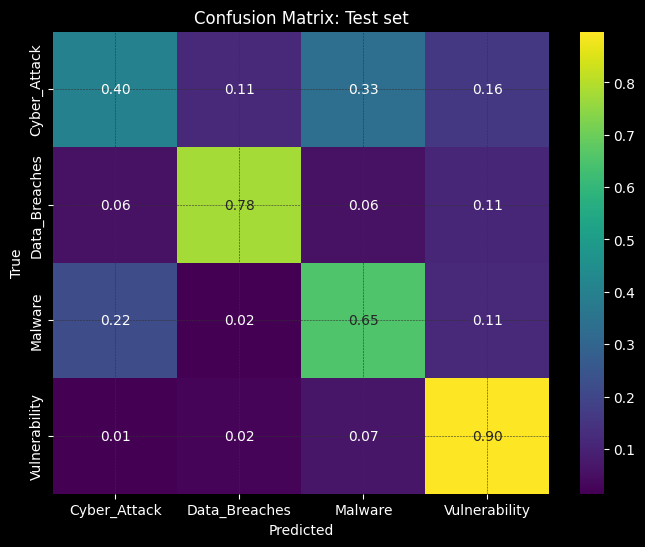

In [54]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='.2f', cmap='viridis',
    xticklabels=id2label.values(),
    yticklabels=id2label.values()
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Test set')
plt.show()

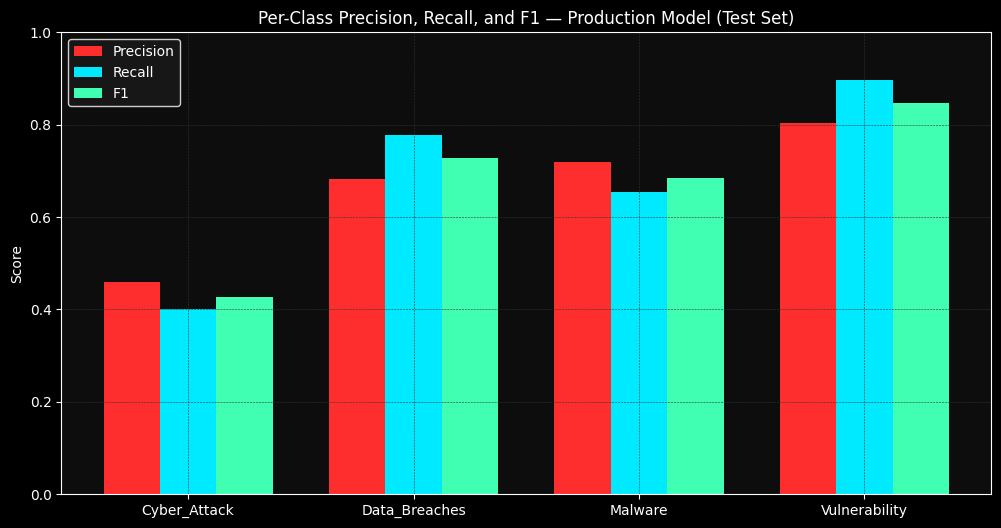

In [55]:
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, zero_division=0
)

labels = list(id2label.values())
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, precision, width, label="Precision")
plt.bar(x, recall, width, label="Recall")
plt.bar(x + width, f1, width, label="F1")

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Per Class Precision, Recall, and F1: Test-set")
plt.ylim(0, 1)
plt.legend()
plt.show()
